# Phase Transitions in a 2D Ferromagnetic Ising Spins

In [1]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit # Fantastic jit optimization compiler_in its efficient performance mode(EPM)

In [2]:
def randomstate(L):
    '''
    Returns a random state of Ising configuration to ascertain an initial condition
    '''
    state = np.random.choice([-1,1], size=(L,L))
    return state

<function matplotlib.pyplot.show(close=None, block=None)>

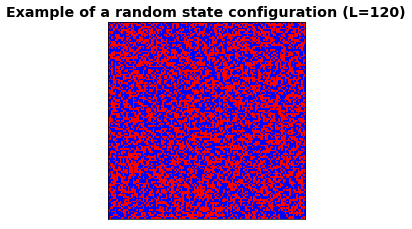

In [3]:
random_confg=randomstate(120)
fig,ax=plt.subplots(figsize=(4,4),dpi=64)
ax.matshow(random_confg, cmap=plt.cm.bwr)
ax.set_xticks([]),ax.set_yticks([])
plt.title("Example of a random state configuration (L=120)", fontsize = 16,fontweight="bold")
plt.show

## Metropolis Monte Carlo Dynamics (MMCD)
* This notebook demonstrates simple example that support the findings of the study [report](#http://arxiv.org/abs/2403.06162:2403.06162) "Nonequilibrium phase transitions in a 2D Ferromagnetic spins with effective interactions".
 * In the [report](#http://arxiv.org/abs/2403.06162:2403.06162) the most commonly used transition rates namely the Metropolis update rule is defined as
$$
W =  \texttt{MIN} \left[1, \exp\left[ -\beta  \Delta E \right]\frac{}{}\right]\texttt{,}
$$
where $\beta = 1/T$ and $ \Delta E $ is the energy change due to the transition from a present state to a new one. 
* It has been shown that this change in energy is given as
$$
 \Delta E =   (1+ h) dE^{0}  \texttt{,}
$$
where $h$ is an effective parameter and $ d E^{0} = \Delta E (h=0)$ is well-known.
* We modify the update rule by replacing $\Delta E =   (1+ h) d E^{0} $ with its new form, $dE$. This can be done through introducing that
$$
h d E^{0} =  h |d E^{0}| \texttt{,}
$$
and thus the modified $\Delta E \to dE$ becomes
$$
  dE =   d E^{0} + h |d E^{0}|.
$$
* It is now one may ask how $dE =   \Delta E^{0} + h |\Delta E^{0}| $ is different from (and similar to) $\Delta E =   (1+ h) \Delta E^{0} $?
* Therefore, this notebook tries to briefly explain and demonstrate how the modified update rule works.

### Detailed Balance (DB):  Does the modified update rule satisfy the DB condition?
There are different ways of the calculation of change in energy ($\Delta E\to \texttt{dE}$) but may have different interpretations. Here we aim to use the one that does NOT satisfy DB (Detailed Balance) condition,
 *  $\texttt{ dE0 = 2*Si*Sjn}$ \;    and  
 *  $\texttt{ dE = dE0+h*abs(dE0)}$,  where
$$
\texttt{dE0} = 2 S_{i} \sum_j S_{j} \equiv \{-8,-4,0,4,8\},
$$
is the change in the energy if the flip is accepted for the usual Metropolis update rule. 
#### MMCD ($-1<h<\infty $)
The parameter $h$ is introduced to play the role of violating DB which is effective for $-1<h<1$, but one can try for any $-1<h<\infty $. 
* Example: $h=\{-1.0, -0.5, -0.25, 0, 0.25, 0.5, 1.0, 1.5...\}$
* Notice that the modified $\texttt{ dE = dE0+h*abs(dE0)}$ can equally be written as  $\texttt{dE = 2.*(Si*Sjn+h*abs(Si*Sjn))}$ or 
\begin{equation}\texttt{dE = 2.*(Si*Sjn+h*abs(Sjn))}\end{equation}
* If the update rule satisfies DB and indeed generates equilibrium configurations, no need to modify $\texttt{dE}$. That is;
$$\Delta E  \leftarrow \texttt{ dE= 2*(Si*Sjn*(1+h).}$$
Therefore, by using the $\texttt{ if condition}$:
* If $\texttt{DB=False}$, $\texttt{dE = 2*(Si*Sjn+h*abs(sjn))}$; else if $\texttt{DB=True}$, $\texttt{dE = 2*(Si*Sjn*(1+h)}$, we can check outputs of the simulation.
* The modified update rule works as:

* Equivalently this can be implemented as follows.
### Block of functions used in the $ \texttt{Main}$ part

In [4]:
def mmcd(confg,beta,DB):
    '''
    Metropolis MC Dynamics
    confg = Configuration of 2D Ising state
    beta = 1./T
    DB:= Detailed Balance '''
    for k in range(L):
        for l in range(L):            
            x = np.random.randint(0, L)
            y = np.random.randint(0, L)
            si = confg[x,y]
            '''
            sjn = sum_j of nearest-neighbors'''
            sjn = confg[(x+1)%L,y]+confg[x,(y+1)%L]+confg[(x-1)%L,y]+confg[x,(y-1)%L] 
            dE0 = 2.*si*sjn
            '''
            DeltaE = 2.*si*sjn*(1+h)'''      # DB = True
            if DB==False:
                '''
                dE = 2.0*(si*sjn+h*abs(si*sjn)) or ''' 
                dE = 2.*(si*sjn+h*abs(sjn))     # DB = False 
            else: dE = 2.*si*sjn*(1+h)          # dE = DeltaE
            if dE < 0:
                si *= -1
            elif rand()< np.exp(-beta*dE):
                si *= -1
            confg[x, y] = si
    return confg
def EvEnergy(confg,DB):
    '''
    Evaluate an energy of the confg
    '''
    energy=0.
    for i in range(len(confg)):
        for j in range(len(confg)):
            Si = confg[i,j]
            Sjn = confg[(i+1)%L,j]+confg[i,(j+1)%L]+confg[(i-1)%L,j]+confg[i,(j-1)%L]
            energy -= Si*Sjn*(1.0+h)
    return 0.5*energy      # 0.5 compensates the double counting
def EvMagnetization(confg):
    '''
    Evaluate Magnetization of the confg
    '''
    magnetization = np.sum(confg)
    return np.abs(magnetization)

### Input Parameters

In [5]:
'''
Effective Parameter: {-1<h<1} but we can use any h>-1 as well.
Try to switch between different values of h and see how it works.
Example: h = {-0.8, -0.5, -0.25, 0.25,0.5, 1,1.5, ...}
int(np.abs(Thi-Tlo)*20+1)  use dt = 0.05 (Optional)'''
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
h = 1.0     
'''
'Default h = \pm 0.25'''
Thi = 3.6*(1.0+h)  # The starting high (hot) temperature
Tlo = 0.75+h      # The low (cold) temperature 
nt = int(51)      # number of temperature
T  =  np.linspace(Thi, Tlo,nt);
TcO = 2.0/np.log(1.0+np.sqrt(2))      # Tc for h = 0 is known
Tcdb= (1.0+h)*TcO                     # Tc for db = True
if h>=1:
    Tch=2.0*TcO
elif h<1 and h>-1: 
    Tch = (1.0+h)*TcO                 # Tc for db = False
else: Tch = 0

In [6]:
Thi,Tlo,nt,Tcdb,Tch

(7.2, 1.75, 51, 4.538370628426044, 4.538370628426044)

In [7]:
'''
For fast simulation, please change the following  parameters each to its minimal value 
'''
L       = 20         #  size of the lattice, N = L x L
eqMCS = 4000         #  number of MCS for equilibration
evMCS = 4000         #  number of MCS for evaluation or measurement
N = int(L*L)
n1 = 1.0/(evMCS*N)
n2  =  1.0/(evMCS*evMCS*N)
m,E = np.zeros(nt),np.zeros(nt)
X,C =  np.zeros(nt),np.zeros(nt)

### The $ \texttt{Main}$ part 

In [8]:
def main(DB):
    for t in range(nt):
        '''
        initialize'''
        confg = randomstate(L)
        M1=E1 = 0
        M2=E2 = 0
        iT=1./T[t]; iT2=iT*iT;

        for i in range(eqMCS):           # equilibrate
            mmcd(confg,iT,DB)           # Metropolis MC Dynamics

        for i in range(evMCS):
            mmcd(confg,iT,DB)       
            En = EvEnergy(confg,DB)       # evaluate the energy
            Mn  = EvMagnetization(confg)  # evaluate the magnetisation
            E1 = E1 + En
            M1 = M1 + Mn
            M2 = M2 + Mn*Mn
            E2 = E2 + En*En
        '''
        obtain intensive values ''' 
        m[t] = n1*M1
        E[t] = n1*E1
        X[t] = (n1*M2 - n2*M1*M1)*iT
        C[t] = (n1*E2 - n2*E1*E1)*iT2
    return DB

In [9]:
'''
DB = True: Satisfies the condition of DB'''
main(True)

True

 ###  Calculated values of the quantities in which the update rule satisfies DB condition

In [14]:
'''
Data frame (df) refers to the results calculated in which DB = True'''
df = pd.DataFrame({'Mdb':m, 'Xdb': X, 'Edb':E, 'Cdb': C})

In [11]:
'''
DB = False: Does not satisfy the condition of DB for |h|<1'''
main(False)

False

### Plot the calculated values of the quantities ($h$)

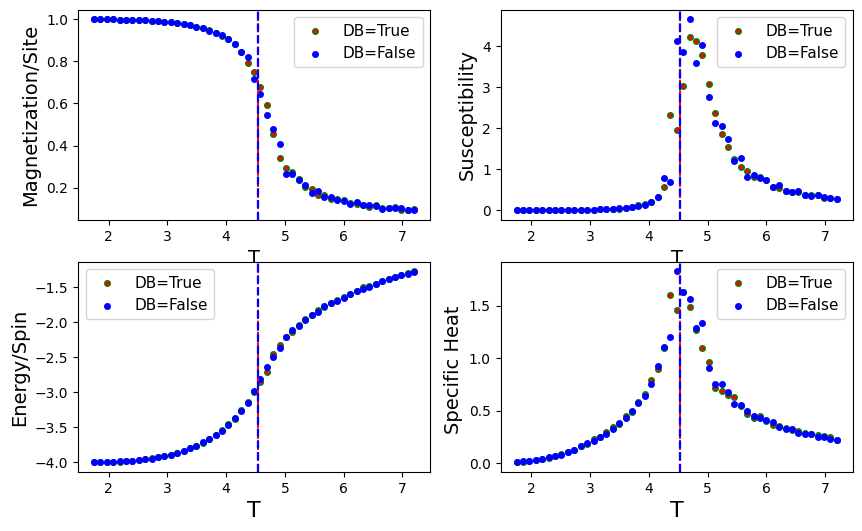

In [12]:
'''
Plot of the calculated quantities 
'''
dot = int(16)
x=T
f = plt.figure(figsize=(10, 6));
#plt.title("Plots of the calculated physical quantities", fontsize=16)
sf = f.add_subplot(2,2,1);
sf.scatter(x, df["Mdb"], s=dot, marker='o', color='g',label="DB=True",fc="r");
plt.axvline(Tcdb, c='r', ls ='--', lw='1.5');
plt.scatter(x, m, s=dot, marker='o', color='b', label = "DB=False");
plt.axvline(Tch, c='b', ls ='--', lw='1.6');
plt.xlabel("T", fontsize=14); 
plt.ylabel("Magnetization/Site", fontsize=14); plt.axis('tight');
plt.legend(fontsize=11)
sf = f.add_subplot(2,2,2);
sf.scatter(x, df["Xdb"], s=dot, marker='o', color='g',label = "DB=True",fc="r");
plt.axvline(Tcdb, c='r', ls ='--', lw='1.5');
sf.scatter(x, X, s=dot, marker='o', color='b', label = "DB=False");
plt.axvline(Tch, c='b', ls ='--', lw='1.6');
plt.xlabel("T", fontsize=14); 
plt.ylabel("Susceptibility", fontsize=14);   plt.axis('tight');
plt.legend(fontsize=11)
sf = f.add_subplot(2,2,3);
sf.scatter(x,df["Edb"], s=dot, marker='o', color='g',label = "DB=True",fc="r");
plt.axvline(Tcdb, c='r', ls ='--', lw='1.5');
sf.scatter(x, E, s=dot, marker='o', color='b', label = "DB=False");
plt.axvline(Tch, c='b', ls ='--', lw='1.6');
plt.xlabel("T", fontsize=16);
plt.ylabel("Energy/Spin", fontsize=14); plt.axis('tight');
plt.legend(fontsize=11)
sf=f.add_subplot(2,2,4);
sf.scatter(x, df["Cdb"],s=dot, marker='o', color='g',label = "DB=True",fc="r");
plt.axvline(Tcdb, c='r', ls ='--', lw='1.5');
sf.scatter(x, C, s=dot, marker='o', color='b', label = "DB=False");
plt.axvline(Tch, c='b', ls ='--', lw='1.6');
plt.xlabel("T", fontsize=16);  
plt.ylabel("Specific Heat ", fontsize=14);   plt.axis('tight');
plt.legend(fontsize=11)
plt.show()

### Figure:
* Plots of physical quantities magnetization per site, magnetic susceptibility, energy per spin and specific heat all as a function of temperature $T$. For a given $h$, the position vertical dash lines (blue and red) provide estimate of $T_{c}$ in each of the two conditions (see keys).